In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import json

In [2]:
# Loading the data from 

data = mne.io.read_raw_eeglab('ear_eeg\sub-001\ses-001\eeg\sub-001_ses-001_task-sleep_eeg.set')
events = pd.read_csv('ear_eeg\sub-001\ses-001\eeg\sub-001_ses-001_task-sleep_acq-scoring_events.tsv', sep='\t')

with open("channels_map.json", 'r') as f:
    channels_map = json.load(f)
    f.close()

with open("channels_group.json", 'r') as f:
    channels_group = json.load(f)
    f.close()

total_time = data.n_times / data.info['sfreq']
print(f"EEG data have {data.n_times} time points, equal to {total_time/60} minutes --> can be divide into {total_time/30} epochs")
print(f"Events have {len(events)} lengths.")
data.set_channel_types(channels_map)

events = events.to_numpy()

# check if n_epoch is equal
assert round(total_time/30) == round(len(events)), "eeg data n_epochs not equal to label n_epochs"

Reading c:\Users\tiger\VScode project\eeg_sleep_stage\ear_eeg\sub-001\ses-001\eeg\sub-001_ses-001_task-sleep_eeg.fdt
EEG data have 5557600 time points, equal to 463.1333333333333 minutes --> can be divide into 926.2666666666667 epochs
Events have 926 lengths.


C:\Users\tiger\AppData\Local\Temp\ipykernel_19156\3243268303.py:17: RuntimeWarning: The unit for channel(s) DC1, DC2, DC3, DC4, DIF2, DIF3, DIF4, Event, OSAT has changed from V to NA.
  data.set_channel_types(channels_map)


In [3]:
event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,
    'Sleep stage R': 5
}

# Selecting only scalp EEG channels
scalp_eeg = data.pick(channels_group['scalp_channels'])
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
scalp_eeg.set_montage(ten_twenty_montage)

<RawEEGLAB | sub-001_ses-001_task-sleep_eeg.fdt, 8 x 5557600 (27788.0 s), ~18 kB, data not loaded>

In [4]:
tmax = 30.0 - 1.0 / data.info['sfreq']  # tmax in included

epochs = mne.Epochs(raw=data, events=events, event_id=event_id,
                    baseline=None, preload=True,
                    tmin=0, tmax=tmax, proj=False)
print(epochs)

Not setting metadata
926 matching events found
No baseline correction applied
Loading data for 926 events and 6000 original time points ...
0 bad epochs dropped
<Epochs |  926 events (all good), 0 – 29.995 s, baseline off, ~339.1 MB, data loaded,
 'Sleep stage W': 71
 'Sleep stage 1': 155
 'Sleep stage 2': 25
 'Sleep stage 3/4': 422
 'Sleep stage R': 253>


In [5]:
X, y = epochs.get_data(), epochs.events[:, -1]

# we have to subtract 1 because the events file uses 1-based indexing
y = y - 1

wave, labels = X[0], y

print('wave', wave.shape, wave)
print('labels', labels)

wave (8, 6000) [[-4.47944908e-05 -4.42628059e-05 -4.47944908e-05 ... -1.07666283e-05
  -1.12983141e-05 -1.28933697e-05]
 [ 3.41607857e-05  3.52241554e-05  3.20340424e-05 ... -1.22686394e-04
  -1.22952240e-04 -1.21091339e-04]
 [-2.19187286e-04 -2.17326385e-04 -2.16528870e-04 ... -1.83298523e-04
  -1.84096054e-04 -1.84361893e-04]
 ...
 [-8.37404442e-06 -4.12056160e-06 -2.52550554e-06 ... -4.91808939e-06
  -5.98146009e-06 -3.05719090e-06]
 [-3.41607857e-05 -3.30974121e-05 -3.62875252e-05 ... -2.51221333e-05
  -2.85780888e-05 -3.04389877e-05]
 [ 3.32303357e-06  4.91808939e-06  9.30449367e-07 ... -5.98146009e-06
  -7.04483080e-06 -8.10820198e-06]]
labels [2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 3 3 3 2 2 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 0 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4
 3 3 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 2 3 2 1 3 1 3 3 3 3 0 0 3 3 3 3 3 3 3 3
 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4

In [6]:
sfreq = epochs.info['sfreq']

# Creating Torch model of 1d-convolutional nn

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data sampling rate", sfreq)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Data sampling rate 200.0
X_train (740, 8, 6000)
y_train (740,)
X_test (186, 8, 6000)
y_test (186,)


In [9]:
y_train[0]

3

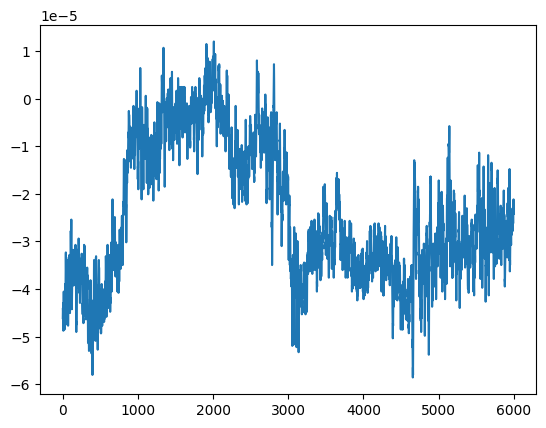

In [10]:
plt.plot(X_train[0][0])

In [11]:
class SleepDataset(Dataset):
    def __init__(self, data, labels, sfreq):
        self.data = data
        self.labels = labels
        self.sfreq = sfreq

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.labels[idx]

        X = torch.from_numpy(X).float().to(device)
        y = torch.tensor(y).long().to(device)
        
        return X, y
        

In [12]:
train_dataset = SleepDataset(X_train, y_train, sfreq=sfreq)
test_dataset = SleepDataset(X_test, y_test, sfreq=sfreq)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [13]:
# # test data loader function
# train_data, train_labels = next(iter(train_dataloader))
# print("Train Data shape in batch is: ", train_data.shape)
# print("data samples:", train_data[0][0])
# print("labels in batch is ", train_labels.shape)
# print('\n')
# test_data, test_labels = next(iter(test_dataloader))
# print("Test Data shape in batch is: ", test_data.shape)
# print("data samples:", test_data[0][0])
# print("labels in batch is ", test_labels.shape)

## Defining a convolutional model

we will use output of 5 classes sleep stage classification

In [14]:
class conv_net(nn.Module):

    def __init__(self):
        super(conv_net, self).__init__()

        self.conv1 = nn.Conv1d(8, 64, 5, padding='same')
        self.conv2 = nn.Conv1d(64, 128, 5, padding='same')
        self.conv3 = nn.Conv1d(128, 128, 5, padding='same')
        self.conv4 = nn.Conv1d(128, 64, 5, padding='same')
        self.conv5 = nn.Conv1d(64, 32, 5, padding='same')

        self.fc1 = nn.Linear(32*6000, 50)
        self.fc2 = nn.Linear(50, 5)

    def forward(self, x):
        # 5 1dconvolutional layers
        x = self.conv1(x)
        x = nn.BatchNorm1d(64, device=device)(x)
        x = nn.ReLU()(x)
        
        x = self.conv2(x)
        x = nn.BatchNorm1d(128, device=device)(x)
        x = nn.ReLU()(x)

        x = self.conv3(x)
        x = nn.BatchNorm1d(128, device=device)(x)
        x = nn.ReLU()(x)

        x = self.conv4(x)
        x = nn.BatchNorm1d(64, device=device)(x)
        x = nn.ReLU()(x)

        x = self.conv5(x)
        x = nn.BatchNorm1d(32, device=device)(x)
        x = nn.ReLU()(x)

        x = x.view(-1, 32*6000)

        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)

        x = nn.LogSoftmax(dim=1)(x)

        return x # return logits from forward network


In [15]:
# test model architecture
model = conv_net().to(device)
print(model)
random_input = torch.randn(64, 8, 6000).to(device)
logits = model(random_input)


conv_net(
  (conv1): Conv1d(8, 64, kernel_size=(5,), stride=(1,), padding=same)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv3): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv4): Conv1d(128, 64, kernel_size=(5,), stride=(1,), padding=same)
  (conv5): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=same)
  (fc1): Linear(in_features=192000, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
)


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        logits = model(X)
        loss = loss_fn(logits, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    conf_matrix_sum = None

    with torch.no_grad():
        for X, y in dataloader:
            prob = model(X)
            pred = prob.argmax(1)

            test_loss += loss_fn(prob, y).item()
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct): >0.1f}%, Avg loss: {test_loss:>8f} \n")

    return conf_matrix_sum


In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1} \n---------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1 
---------------------
loss: 1.574499  [    0/  740]
loss: 7.704075  [  160/  740]
loss: 3.389592  [  320/  740]
loss: 2.568245  [  480/  740]
loss: 0.981701  [  640/  740]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.076383 

Epoch 2 
---------------------
loss: 0.910520  [    0/  740]
loss: 1.031443  [  160/  740]
loss: 0.478661  [  320/  740]
loss: 0.758099  [  480/  740]
loss: 0.962133  [  640/  740]
Test Error: 
 Accuracy: 53.2%, Avg loss: 1.187441 

Epoch 3 
---------------------
loss: 0.742537  [    0/  740]
loss: 1.280141  [  160/  740]
loss: 0.814008  [  320/  740]
loss: 0.340541  [  480/  740]
loss: 0.937492  [  640/  740]
Test Error: 
 Accuracy: 67.2%, Avg loss: 0.948622 

Epoch 4 
---------------------
loss: 0.580213  [    0/  740]
loss: 0.520922  [  160/  740]
loss: 0.935804  [  320/  740]
loss: 0.591655  [  480/  740]
loss: 0.768977  [  640/  740]
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.126114 

Epoch 5 
---------------------
loss: 0.679503  [    0/  740]
loss: 0

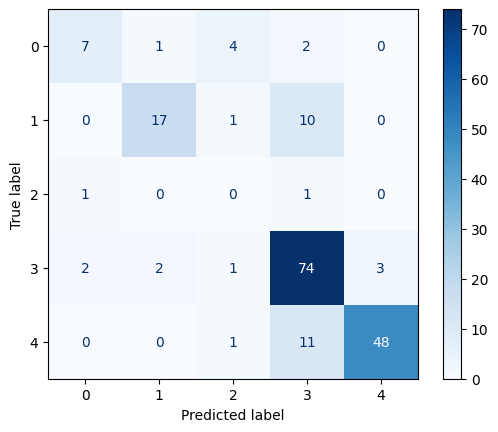

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# visualize model prediction

testtest_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

for X, y in testtest_dataloader:

    prob = model(X)
    pred = prob.argmax(1)

    conf = confusion_matrix(y.cpu().numpy(), pred.cpu().numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
disp.plot(cmap='Blues')
plt.show()